### What is ARIMA?

- ARIMA (Auto-Regressive Integrated Moving Average) is a general class of statistical models for time series analysis forecasting
- ARIMA uses a time series' past values and/or forecast errors to predict its future values
- ARIMA model assumption - stationary: the time series has its statistical properties remain constant across time
- Three components/parameters: AR + I + MA (p, d, q)


https://www.youtube.com/watch?v=-aCF0_wfVwY


### ARIMA(p, d, q)

- **AR (Auto-Regressive)**: the time series is linearly regressed on its own past values
  - p: the number of past values included in the AR model

- **I (Integrated)**: if not stationary, the time series can be differenced to become stationary
  - d: the number of times the time series is differenced

- **MA (Moving Average)**: the time series is ‘regressed’ on the past forecast errors
  - q: the number of past forecast errors included in the MA model


In [16]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import json

In [17]:
# Assuming 'data' is the JSON object containing the time series data provided by the user.

# Step 1: Load the data into a DataFrame
# Here we extract only the 'close' prices for the ARIMA model
# data = {
#     "2024-01-10": {"4. close": "161.2300"},
#     "2024-01-05": {"4. close": "159.1600"},
#     "2023-12-29": {"4. close": "163.5500"},
#     "2023-12-22": {"4. close": "162.1400"},
#     "2023-12-15": {"4. close": "162.2300"},
#     "2023-12-08": {"4. close": "161.9600"},
# }

file_path = '../DataInputs/amazon_weekly_close.json'  # Replace with your file path
with open(file_path, 'r') as file:
    data = json.load(file)

In [18]:

# # Convert the dictionary to a pandas DataFrame
# df = pd.DataFrame.from_dict(data, orient='index')
# df.index = pd.to_datetime(df.index)
# df['4. close'] = df['4. close'].astype(float)


# Convert the dictionary to a pandas DataFrame
df = pd.DataFrame(list(data.items()), columns=['Date', 'Close'])
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df['Close'] = df['Close'].astype(float)

In [19]:
df

,Close
Date,
2024-01-05,145.2400
2023-12-29,151.9400
2023-12-22,153.4200
2023-12-15,149.9700
2023-12-08,147.4200
...,...
1999-12-10,5.3350
1999-12-03,4.3280
1999-11-26,4.6565


In [22]:

# Step 2: Check for stationarity
# Corrected adfuller check
result = adfuller(df['Close'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

# Correct the conditional statement for differencing
if result[1] > 0.05:
    df['Close_diff'] = df['Close'].diff().dropna()


ADF Statistic: -1.895302312203678
p-value: 0.3342742683539027


In [23]:
# Since the data is every Friday, we use 'W-FRI' to indicate weekly frequency on Fridays
df = df.asfreq('W-FRI')

# Ensure the data is sorted after setting the frequency
df.sort_index(inplace=True)

In [24]:
# Step 4: Fit the ARIMA model
# Here we arbitrarily choose (1,1,1) for (p,d,q). In practice, you would use model selection techniques.
model = ARIMA(df['Close'], order=(1, 1, 1))
model_fit = model.fit()


In [25]:

# Step 5: Summarize the model
model_summary = model_fit.summary()
print(model_summary)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1261
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2975.863
Date:                Thu, 11 Jan 2024   AIC                           5957.726
Time:                        18:02:37   BIC                           5973.142
Sample:                    11-12-1999   HQIC                          5963.519
                         - 01-05-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9438      0.009   -108.033      0.000      -0.961      -0.927
ma.L1          0.9892      0.006    153.981      0.000       0.977       1.002
sigma2         7.5360      0.115     65.496      0.0

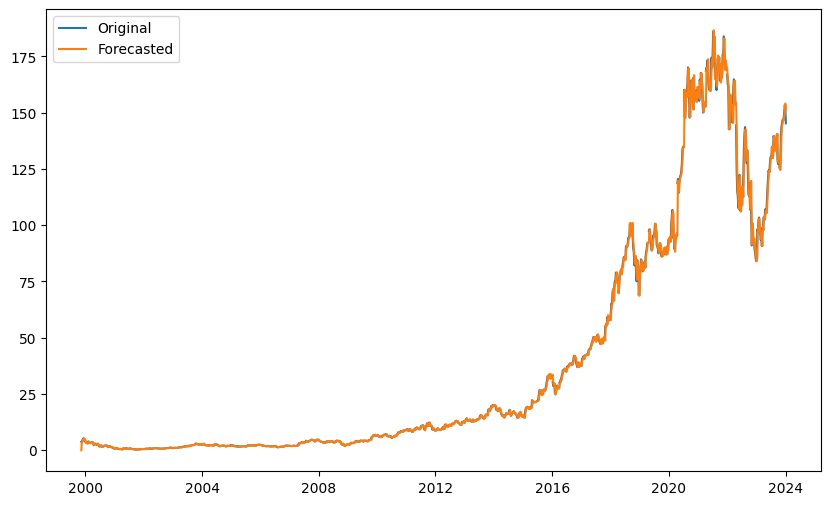

In [26]:

# Step 6: Plot the original series and the forecasted series
df['forecast'] = model_fit.predict(start=0, end=len(df)-1, typ='levels')
plt.figure(figsize=(10,6))
plt.plot(df['Close'], label='Original')
plt.plot(df['forecast'], label='Forecasted')
plt.legend()
plt.show()

# The steps above give a basic framework for fitting an ARIMA model to a time series.
# There are additional steps you would take in practice, including:
# - Examining ACF and PACF plots to choose p and q
# - Performing cross-validation or using information criteria like AIC to select the best model
# - Checking the residuals of the model to ensure no patterns (indicating a good fit)


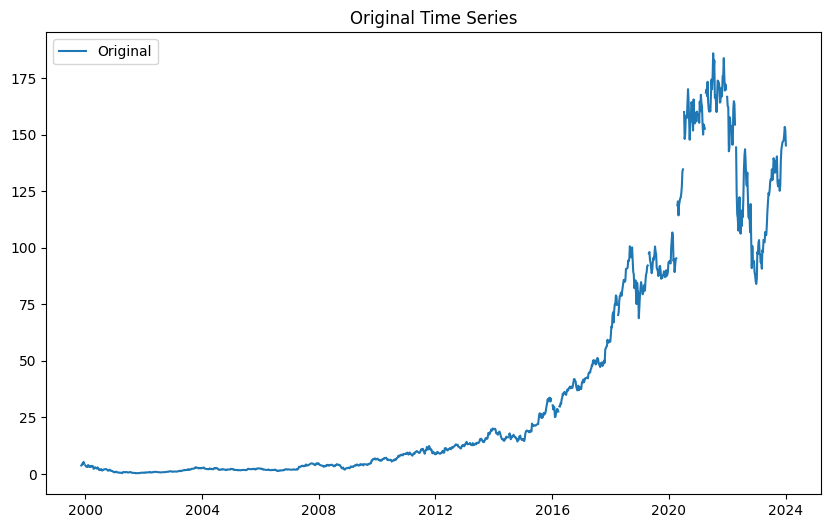

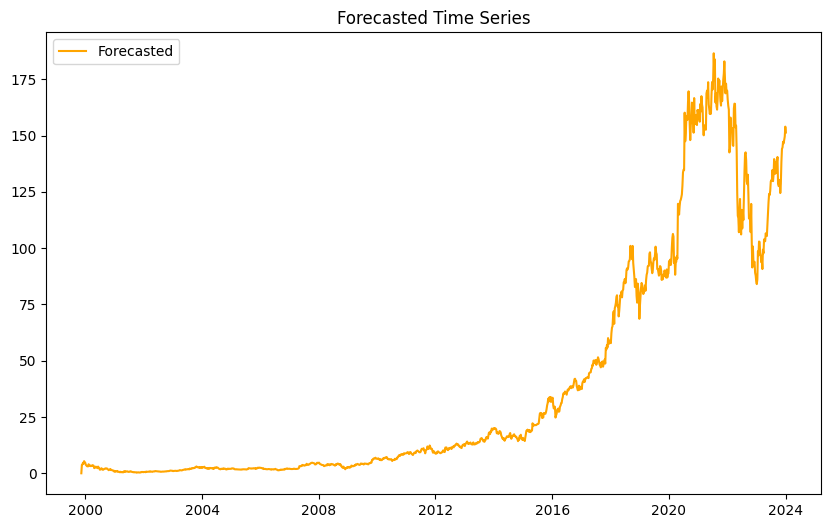

In [27]:
# Assuming 'df' is your DataFrame and 'model_fit' is your fitted ARIMA model

# Plot the original series
plt.figure(figsize=(10,6))
plt.plot(df['Close'], label='Original')
plt.title('Original Time Series')
plt.legend()
plt.show()

# Generate the forecasted series
df['forecast'] = model_fit.predict(start=0, end=len(df)-1, typ='levels')

# Plot the forecasted series
plt.figure(figsize=(10,6))
plt.plot(df['forecast'], color='orange', label='Forecasted')
plt.title('Forecasted Time Series')
plt.legend()
plt.show()


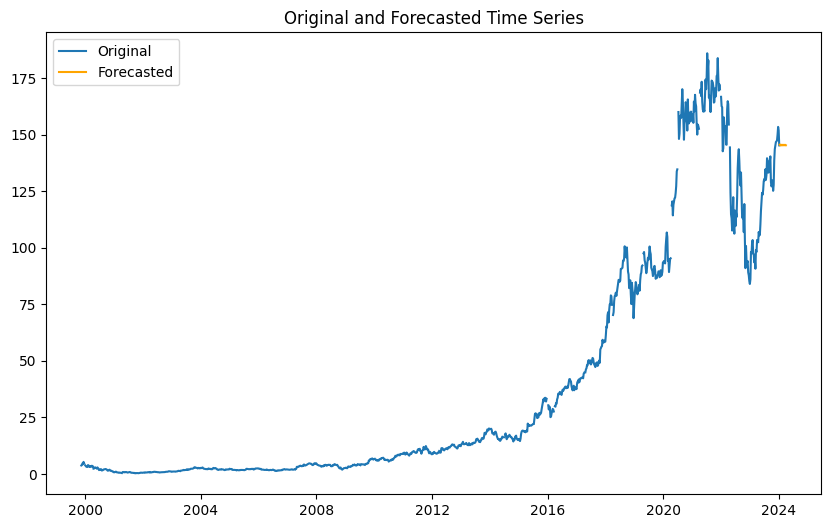

In [28]:
# Assuming the rest of your code is unchanged and your model is already fitted...

# Define the number of steps to forecast (12 weeks for roughly 3 months)
n_steps = 12

# Get the last date from the index
last_date = df.index[-1]

# Generate forecast for the next 12 weeks
forecast = model_fit.get_forecast(steps=n_steps)

# Get the forecast index starting the next period after the last date
forecast_index = pd.date_range(start=last_date, periods=n_steps+1, freq='W-FRI')[1:]

# Create a series for the forecasted values
forecast_series = pd.Series(forecast.predicted_mean, index=forecast_index)

# Plot the original series and the forecasted series
plt.figure(figsize=(10,6))
plt.plot(df['Close'], label='Original')
plt.plot(forecast_series, label='Forecasted', color='orange')
plt.legend()
plt.title('Original and Forecasted Time Series')
plt.show()
